# Movie Reccomender System

In [4]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Create a custom palette using HEX codes 
palette = sns.color_palette(["#FF6B6B", "#4ECDC4", "#45B7D1","#FAD02E", "#594F4F"])
# Machine Learning Libraries
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

## Phase 1 - Data and Setup

The goal of this phase is to prepare the data in pandas DataFrames, investiage the features of the dataset, and inform us on model selection

### Loading Datasets into Pandas Dataframes

In [505]:
ratings_df = pd.read_csv('datasets/ratings.csv')
ratings_df = ratings_df.drop('timestamp', axis = 1)
movies_df = pd.read_csv('datasets/movies.csv')

### Merging the 3 Dataframes into One

In [506]:
# Merging the movies_df and the ratings_df
df_merge = ratings_df.merge(movies_df, on = 'movieId' ,how = 'left')
df_merge.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Exploratory Data Analysis

The goal of this section is to investigate our newly created dataset. Some things we will do here,
    - Look at the type of features we have (numerical vs categorical)
    - Examine the missing values of the features
    - Understand the data structure
    - Conduct graphical analysis on the features

#### Data Strucutre Analysis

In [507]:
df_merge.shape

(100836, 5)

In [508]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [509]:
df_merge.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


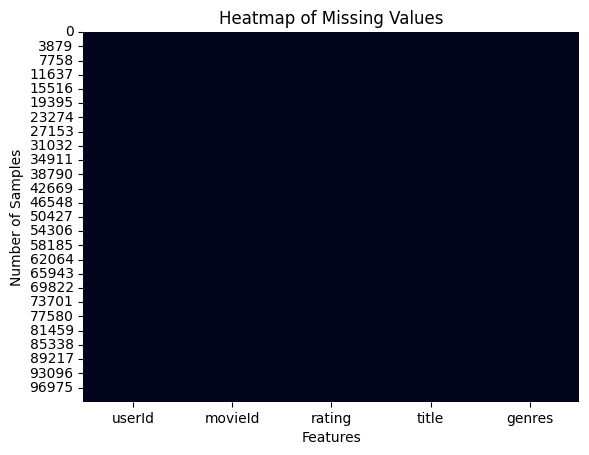

In [510]:
sns.heatmap(df_merge.isna(), cbar = False)
plt.title('Heatmap of Missing Values')
plt.xlabel('Features')
plt.ylabel('Number of Samples')
plt.show()

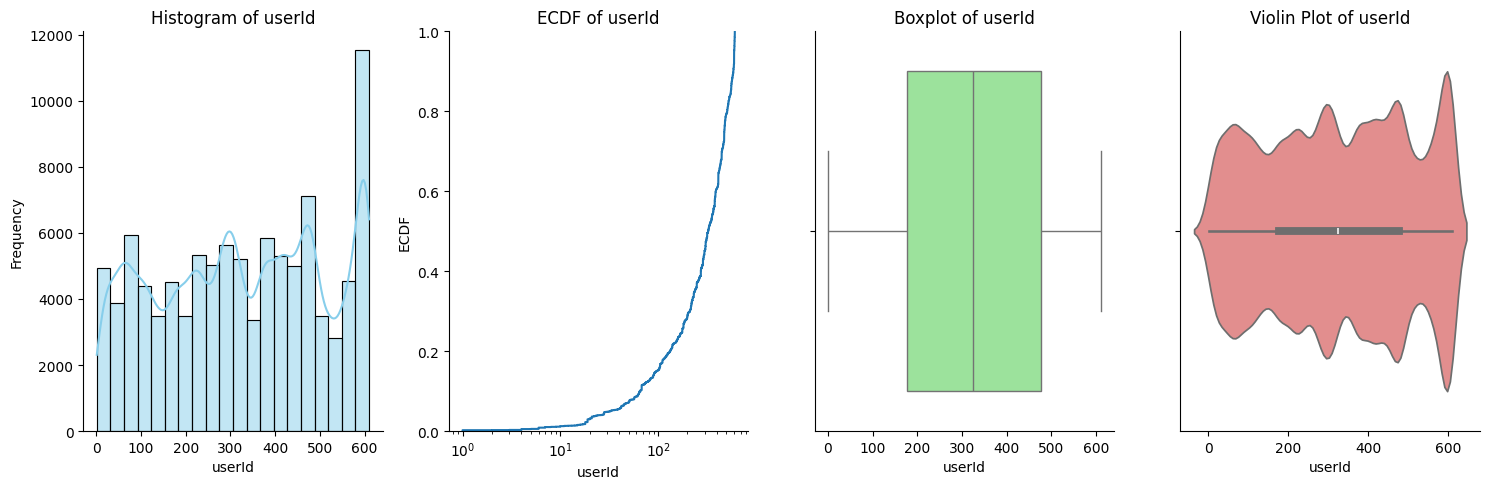

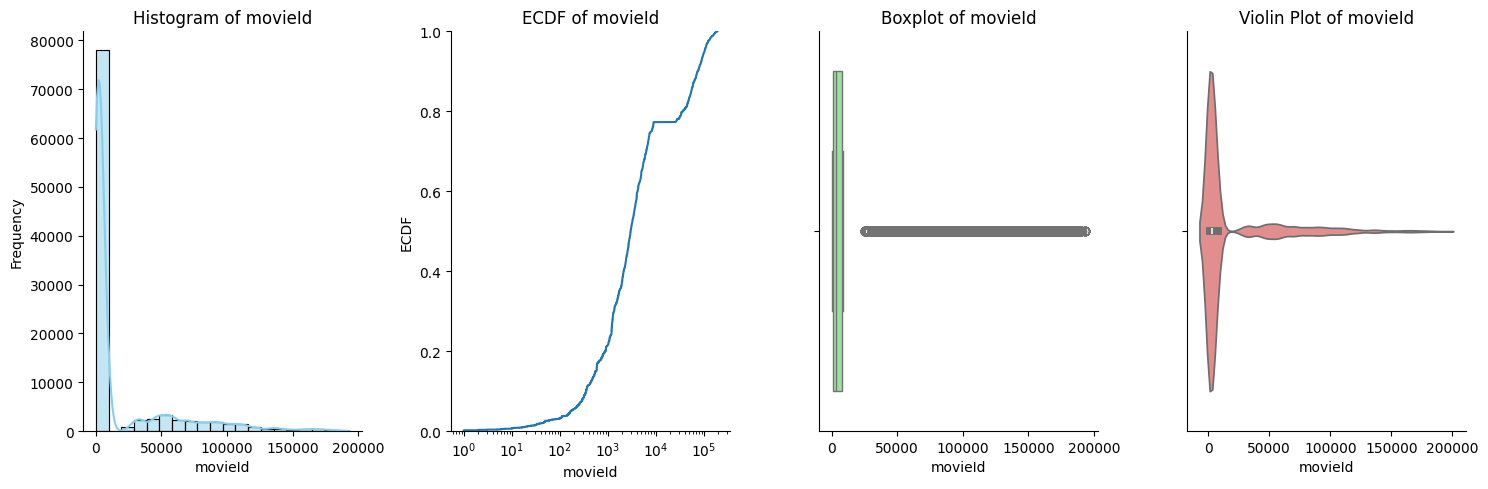

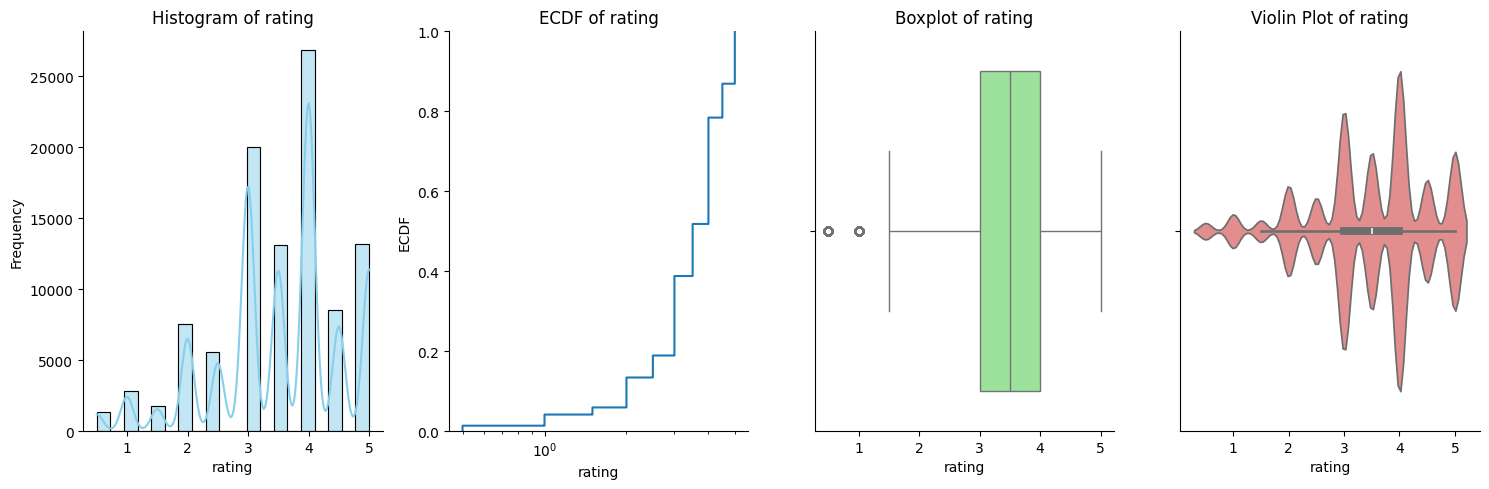

In [511]:
def plot_univariate(df,bins = 20, kde = True):
    
    num_df = df.select_dtypes(include = ['number'])

    for feature in num_df.columns:
        # Numeric feature plotting
        
        plt.figure(figsize=(15, 5))

        # Histogram with KDE
        plt.subplot(1, 4, 1)
        sns.histplot(data=df, x=feature, kde=kde, bins=bins, color="skyblue")
        plt.title(f"Histogram of {feature}", fontsize=12)
        plt.xlabel(feature)
        plt.ylabel("Frequency")

        plt.subplot(1,4,2)
        sns.ecdfplot(data=df, x = feature,log_scale = True)
        plt.title(f"ECDF of {feature}", fontsize=12)
        plt.xlabel(feature)
        plt.ylabel("ECDF")

        # Boxplot (horizontal for better readability)
        plt.subplot(1, 4, 3)
        sns.boxplot(data=df, x=feature, color="lightgreen", showfliers=True)
        plt.title(f"Boxplot of {feature}", fontsize=12)

        # Violin plot
        plt.subplot(1, 4, 4)
        sns.violinplot(data=df, x=feature, color="lightcoral")
        plt.title(f"Violin Plot of {feature}", fontsize=12)

        sns.despine()
        plt.tight_layout()
        plt.show()

plot_univariate(df_merge)

#### Analysis 

Some initial things we can note here is that most of the movies rated, are heavely skewed. From the boxplot we see most of our movies are outliers past the first 25000

We can also notice from the boxplots that our features do not have any significant outliers (aside from movieId). Giving an inital suggestion that Linear, KNN, or SVM models may thrive here

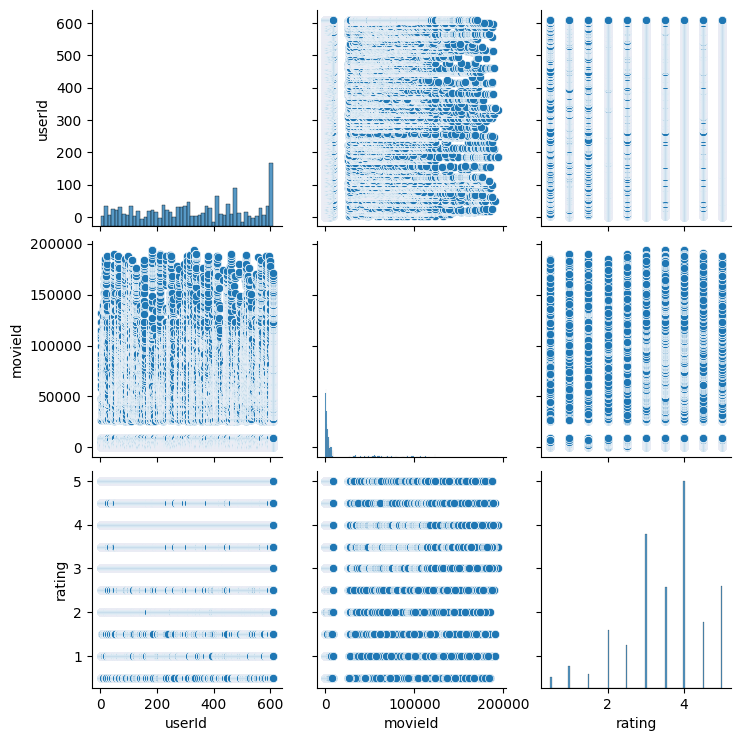

In [512]:
sns.pairplot(df_merge)

<Axes: >

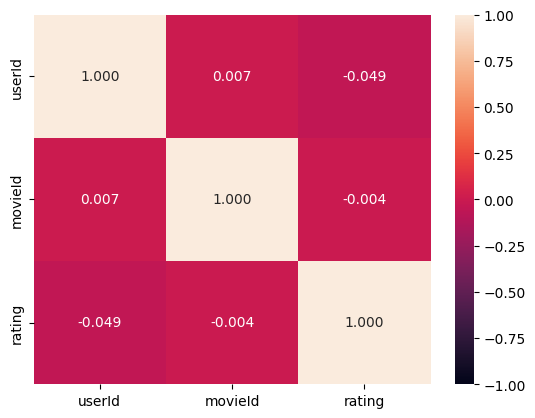

In [513]:
df_corr = df_merge.select_dtypes(include=['number']).corr()
sns.heatmap(df_corr,annot=True, vmin = -1, vmax = 1,fmt = '.3f')

## Feature Investigation

### Movie Title Feature

Some things that initially standout with this, is that in order for later processing we must normalize the text in our titles (Lowercase, remove year, punctuation)

So as we can see for most titles, the years are formatted in the end of the title surrounded by (). Using Regex we can easily remove these from all titles


However, before we do this I think the year the movie was made still provides us some important information that we can use later on. So first I will make a function to extract this info

In [514]:
movies_df['title'].nunique(), len(movies_df['title'])

(9737, 9742)

So we can see our movies df contains some duplicate values, lets drop these

In [515]:
movies_df = movies_df.drop_duplicates(subset=['title'])
len(movies_df['title'])

9737

In [516]:
def extract_year(df):
    '''Takes the data frame and extracts the year sequence from the title and assigns it to a new column'''
    df['year'] = df['title'].str.extract(r'\((\d{4})\)')

extract_year(movies_df)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [517]:
movies_df = movies_df.dropna()
movies_df['year'] = movies_df['year'].astype(int)
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [518]:
def normalize_title(title):
    '''Normalize title feature'''
    return re.sub('[^a-zA-Z\s]','',title).lower() # Goes through all characters in title, that are not a letter or a space and replaces them with nothing

# iterates through each title, and applys the normalize_title function
movies_df['clean_title'] = movies_df['title'].apply(normalize_title)


In [519]:
# Now we can drop the title feature
movies_df = movies_df.drop('title', axis = 1)

In [520]:
movies_df.head()

,movieId,genres,year,clean_title
0,1,Adventure|Animation|Children|Comedy|Fantasy,1995,toy story
1,2,Adventure|Children|Fantasy,1995,jumanji
2,3,Comedy|Romance,1995,grumpier old men
3,4,Comedy|Drama|Romance,1995,waiting to exhale
4,5,Comedy,1995,father of the bride part ii


### Investigating the movieId Feature

So initially what we can look at is reducing the number of movies by looking at movieId's relative to how many times they appear in ratings. Movies that say appear less than 10 times may not be worth keeping in the dataset.

#### Why Should we Remove Them

These movies do not contain/share any important information about the user preferences as there simply is not enough data about them. Furthmore, including them can lead a model, like a random forest, to create splits that perfectly fit these sparse observations. This effectively memorizes noise rather than learning generalizable patterns, which increases sparsity and risks overfitting. Removing these movies ensures the model focuses on items with sufficient data to learn meaningful relationships."


In [521]:
total_rows = len(df_merge)
total_rows

100836

In [522]:
def plot_hist(feature_counts,feature, bins = 50, log = True):
    
    sns.histplot(feature_counts, bins=bins, log=True, edgecolor="black",kde = True)
    plt.xlabel('Number of ratings per movie')
    plt.ylabel(f'Number of {feature} (log scale)')
    plt.title(f'Distribution of Ratings per {feature}')
    plt.show()


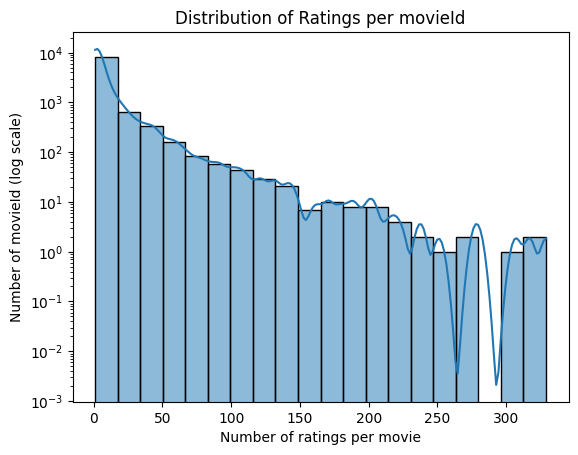

In [523]:
movie_counts = df_merge['movieId'].value_counts()
plot_hist(movie_counts, feature = 'movieId', bins = 20)

From this graph we can see our distribution is skewed to the rightly skewed, meaning most of our movies have low ratings

#### Investigating the userId Feature

Same logic applies from last section, we can investigate 'unique' users or users who do not fit a certain threshold. A person whos only rated a movie a few times does not give us enough data about there preferances, ultimately just adding noise to the dataset


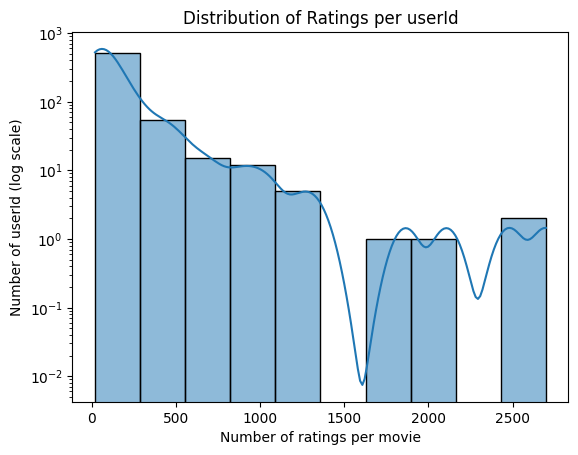

In [524]:
users_counts = df_merge['userId'].value_counts(ascending=True)
plot_hist(users_counts, feature = 'userId',bins = 10)

#### Investigating the Ratings Feature

So from what we can see, our ratings feature contains the average rating of a movie. So Toy Story has an average rating of 4. This issue with this feature as is, is that it does not account for the number of ratings for each movie. So for example Toy Story being a popular movie, would suggest that it would have a few hundred/thousand ratings. Lets say the average rating across the hundreds of ratings is 4. Contrast this to a more unpopular movie with say 10 ratings that has an average rating of also 4. Clearly these 2 movies shouldnt be weighted the same. 

To get around this we can make a rating_density score, measuring the number of ratings for each movie


In [525]:
ratings_df = pd.read_csv('datasets/ratings.csv')
ratings_df = ratings_df.drop('timestamp', axis = 1)
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [526]:
avg_ratings = ratings_df.groupby('movieId').agg(
    number_rating = ('rating','count'),
    average_rating = ('rating','mean')
).reset_index()

avg_ratings.head()

,movieId,number_rating,average_rating
0,1,215,3.920930
1,2,110,3.431818
2,3,52,3.259615
3,4,7,2.357143
4,5,49,3.071429


### Investigating The Genres Feature

We can use the genres feature to recommend other movies based off their similiarity in genres. We can do this by creating a genre vector.

So we can see that the genres are split on '|'. So for us to really assess genres lets splits these

In [527]:
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))
movies_df.head()

,movieId,genres,year,clean_title
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,toy story
1,2,"[Adventure, Children, Fantasy]",1995,jumanji
2,3,"[Comedy, Romance]",1995,grumpier old men
3,4,"[Comedy, Drama, Romance]",1995,waiting to exhale
4,5,[Comedy],1995,father of the bride part ii


Now with our newly encoding genre vectors, we can recommend similiar movies based on genres.
We can do this using knn.

## Phase 2 - Movie Recomendations

The goal of this phase is to recomend movies in 2 ways,

1. By Comparing the genre vectors of 2 movies and use KNN to find nearest movie's with similiar genre vector
2. By comparing movies liked by 'Similiar Users' to us.

We will do this in a few steps:

    1. Extract Features: We will use the genres as features and encode them 
    2. Compute Similiarity: Using the cosine similiarity metric we will measure the similiarity of 2 vectors (movies - movies)
    3. Recommend Function: Then we output movies based on the movies the user likes

But first we must create a search function

### Search Function

We need to be able to take in a user query and output recommended movies

### TF-IDF Matrix

So as we can see, right now our title is currently formatted into text. Machines cannot read text so we will have to encode these numerical so that we can operate with them. **TF-IDF** matrix is one way we can do this.

##### Term Frequencys (TF) and Inverse Document Frequency (IDF)

TF -> Depicts how often a word appear in a document
IDF -> Downweights words that appear frequently, like 'the','is','and'

So the combination of these 2, results in words that are frequent in 1 document and rare in all others being deemed as **important**

##### Example

Doc 1 : 'This movie was funny'  
Doc 2 : 'I love this movie'  
Doc 3 : 'This movie was boring'

- Since **'movie'** appears in all 3 docs, it gets a lower weight.  
- Since **'funny'**, **'boring'**, and **'love'** appear only once in their documents, they get higher weights.

|        | funny | love  | movie | boring | this  | was   |
|--------|-------|-------|-------|--------|-------|-------|
| Doc 1  | 0.707 | 0.000 | 0.354 | 0.000  | 0.354 | 0.607 |
| Doc 2  | 0.000 | 0.707 | 0.354 | 0.000  | 0.354 | 0.000 |
| Doc 3  | 0.000 | 0.000 | 0.354 | 0.707  | 0.354 | 0.607 |


    - Each row = a document
    - Each column = word
    - Cells = TF-IDF Weight (higher = important)
    - Together gives us a vector representing the doc




In [528]:
# Initialize a vectorizer object
vectorizer = TfidfVectorizer(ngram_range=(1,2))
tf_idf= vectorizer.fit_transform(movies_df['clean_title'])

In [561]:
def search_titles(df,title,tf_idf):
    title = normalize_title(title)
    query_vector = vectorizer.transform([title])

    # Compare the query_vector to all titles in the dataset. Returning the similiarity of the query vector to clean_titles
    similiarity = cosine_similarity(query_vector, tf_idf).flatten()

    # Get the 5 titles with the highest similiarty with our query
    top5_idxs = np.argsort(similiarity,)[-5:][::-1]
    # Data Frame of most similiar movies to search query
    results_df = df.iloc[top5_idxs].copy()
    # Create a similiarity_score feature denoting how similiar the score is
    results_df['Similiarity_score'] = similiarity[top5_idxs]

    # movieID index containing the most similiar
    most_similiar_idx = int(results_df['movieId'].values[0])

    
    return results_df, most_similiar_idx

title = str(input('Enter a title to search:'))

results_df, most_similiar_idx = search_titles(movies_df,title,tf_idf)
print(f'\nMovie search results for: {title}')
results_df

Enter a title to search: Harry Potter



Movie search results for: Harry Potter


,movieId,genres,year,clean_title,Similiarity_score
3574,4896,"[Adventure, Children, Fantasy]",2001,harry potter and the sorcerers stone aka harry...,0.571693
7078,69844,"[Adventure, Fantasy, Mystery, Romance, IMAX]",2009,harry potter and the halfblood prince,0.531445
6062,40815,"[Adventure, Fantasy, Thriller, IMAX]",2005,harry potter and the goblet of fire,0.503408
4076,5816,"[Adventure, Fantasy]",2002,harry potter and the chamber of secrets,0.495879
7644,88125,"[Action, Adventure, Drama, Fantasy, Mystery, I...",2011,harry potter and the deathly hallows part,0.485528


### Recommend Based on Genre

#### MultiLabelBinarizer

So these show us the number of unique singular genres in the dataset. So what we can do is these values, and then map these encodings to our genres. Usin


In [541]:
mlb = MultiLabelBinarizer()
genre_vectors = mlb.fit_transform(movies_df['genres'])
genre_df = pd.DataFrame(genre_vectors,columns=mlb.classes_)
genre_df.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [531]:
def recomend_movie_genre(movies_df,genre_df,most_similiar_idx):

    # Numpy array of genre vectors
    X = movies_df.drop(['genres','year','clean_title'], axis = 1)

    # Build KNN Model
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(X)

    # Find the 5 closest neighbours for most_similiar_idx
    distances, idxs = knn.kneighbors(X[X['movieId'] == most_similiar_idx],n_neighbors=5)
    neighbor_ids = movies_df.iloc[idxs[0]]['movieId'].tolist()   
    movie_genre_recs = movies_df[movies_df['movieId'].isin(neighbor_ids)]
    
    print(f"Similar movies to Movie: {most_similiar_idx}")
    print(neighbor_ids)
    print("Distances:", distances)

    return movie_genre_recs

movie_genre_recs = recomend_movie_genre(movies_df,genre_df, most_similiar_idx)
movie_genre_recs

Similar movies to Movie: 2153
[53024, 53000, 53121, 53125, 53022]
Distances: [[0. 0. 0. 0. 0.]]


,movieId,genres,year,clean_title
6483,53000,"[Horror, Sci-Fi, Thriller]",2007,weeks later
6484,53022,"[Action, Comedy, Crime, Romance]",1984,wheels on meals kuai can che
6485,53024,[Documentary],2006,jonestown the life and death of peoples temple
6486,53121,"[Adventure, Animation, Children, Comedy, Fantasy]",2007,shrek the third
6488,53125,"[Action, Adventure, Comedy, Fantasy]",2007,pirates of the caribbean at worlds end


### Recommend Movies based of similiar users.

#### How we will Recomend

So here we will find **similiar users**, and find movies that they also liked. We will define a **similiar user** to be one that rates the searched movie higher than a weighted average. We will then take these similiar users and find the other movies in which they rated highly.

#### The user_reccomendation issue

The movieIDs in user_recommendations represent movies liked by similar users. However, to put these recommendations in context, we also need to look at the movieIDs rated by all users. By comparing the preferences of similar users against the overall user base, we can identify which movies are uniquely favored by the similar users versus those that are broadly popular.

For example, Toy Story has a high average rating of 3.9 across all users, meaning it’s a generally well-liked movie. Since its popularity isn’t specific to our similar users, it doesn’t provide much insight into their unique preferences. This comparison helps us separate universally popular movies from those that are particularly meaningful to the similar user group.

In [535]:
def get_weighted_avg_rating(ratings_df, avg_ratings, most_similar_idx):
    '''Function to get weighted average of ratings'''

    # Global average across all movies
    C = avg_ratings['average_rating'].mean()
    
    # Minimum ratings smoothing factor
    m = 10

    # Movie-specific values
    movie_row = avg_ratings.loc[avg_ratings['movieId'] == most_similar_idx].iloc[0]
    v = movie_row['number_rating']
    R = movie_row['average_rating']

    # Weighted rating
    weighted_avg = (v * R + m * C) / (v + m)
    return weighted_avg


In [536]:
def get_similar_movies(ratings_df, most_similar_idx,avg_ratings, thresh=0.001):
    """
    Find movies recommended by users similar to those who liked the given movie.

    Parameters:
    -----------
    ratings_df : pd.DataFrame
        Ratings data with columns ['userId', 'movieId', 'rating']
    most_similar_idx : int
        The movieId of the query movie
    weight : float, optional
        Weight factor (currently unused)
    thresh : float, optional
        Minimum fraction of similar users who must like a movie for it to be recommended

    Returns:
    --------
    user_recommendations : pd.Series
        Movies liked by similar users (normalized frequencies)
    all_users_recommendations : pd.Series
        Movies liked by all users (normalized frequencies) for comparison
    """

    # Average rating of the query movie
    '''
    rating_value = avg_ratings.loc[
        avg_ratings['movieId'] == most_similar_idx, 'average_rating'
    ].iloc[0]
    '''

    weighted_avg = get_weighted_avg_rating(ratings_df, avg_ratings,most_similar_idx)

    # Users who rated the query movie above its average
    similar_users = ratings_df[
        (ratings_df['movieId'] == most_similar_idx) & (ratings_df['rating'] >= weighted_avg)
    ]['userId'].unique()

    # Movies that similar users rated above the average rating of the query movie
    user_recomendations = ratings_df[
        (ratings_df['userId'].isin(similar_users)) & (ratings_df['rating'] > weighted_avg)
    ]['movieId']

    # Normalize by fraction of recommendations
    user_recomendations = user_recomendations.value_counts(normalize=True)
    user_recomendations = user_recomendations[user_recomendations > thresh]

    # For comparison: how often *all users* like the same set of movies
    all_users = ratings_df[
        (ratings_df['movieId'].isin(user_recomendations.index)) & (ratings_df['rating'] >= weighted_avg)
    ]

    all_users_recomendations = all_users['movieId'].value_counts() / len(all_users['userId'].unique())

    return user_recomendations, all_users_recomendations

In [545]:
user_recomendations, all_user_recomendations = get_similar_movies(ratings_df,most_similiar_idx,avg_ratings)
user_recomendations

movieId
1        0.007012
318      0.004102
356      0.003864
260      0.003721
296      0.003530
           ...   
104      0.001002
440      0.001002
59315    0.001002
68358    0.001002
903      0.001002
Name: proportion, Length: 193, dtype: float64

In [546]:
all_user_recomendations

movieId
318     0.458194
356     0.416388
296     0.408027
593     0.376254
2571    0.371237
          ...   
899     0.061873
2000    0.061873
2985    0.055184
2078    0.053512
596     0.046823
Name: count, Length: 193, dtype: float64

In [538]:
difference = pd.concat(
    [user_recomendations,all_user_recomendations], 
    axis=1, 
    join="inner"   # keep only overlapping movieIds
)
difference.columns = ["Similar", "All"]
difference

,Similar,All
movieId,,
2094,0.002815,0.054817
648,0.002815,0.240864
1265,0.002815,0.220930
733,0.002815,0.186047
368,0.002815,0.111296
...,...,...
1920,0.001407,0.018272
1909,0.001407,0.056478
1907,0.001407,0.064784


So we want the greatest between similiar movies liked and all movies liked, to get unqiue movies best like from just similiar users

In [547]:
difference['score'] = (difference['Similar'] / difference['All'])
difference = difference.sort_values('score', ascending=False)
difference

,Similar,All,score
movieId,,,
2153,0.002815,0.006645,0.423645
1812,0.001407,0.004983,0.282430
513,0.001407,0.006645,0.211823
423,0.002111,0.011628,0.181562
1499,0.001407,0.008306,0.169458
...,...,...,...
2959,0.001407,0.342193,0.004113
110,0.001407,0.362126,0.003887
593,0.001407,0.436877,0.003222


In [548]:
# Getting the top 10 recomended movies, and merging it to the movies_df
difference.head(10).merge(movies_df, left_index = True, right_on = 'movieId')

,Similar,All,score,movieId,genres,year,clean_title
1611,0.002815,0.006645,0.423645,2153,"[Action, Adventure]",1998,avengers the
1338,0.001407,0.004983,0.282430,1812,"[Children, Comedy, Drama]",1998,wide awake
448,0.001407,0.006645,0.211823,513,"[Comedy, Mystery, Romance]",1994,radioland murders
367,0.002111,0.011628,0.181562,423,"[Action, Thriller]",1994,blown away
1145,0.001407,0.008306,0.169458,1499,"[Action, Adventure, Thriller]",1997,anaconda
488,0.001407,0.008306,0.169458,558,"[Action, Adventure, Animation, Children, Fantasy]",1994,pagemaster the
1560,0.001407,0.009967,0.141215,2097,"[Children, Drama, Fantasy, Mystery, Thriller]",1983,something wicked this way comes
222,0.001407,0.009967,0.141215,258,"[Adventure, Children, Comedy, Fantasy, Romance]",1995,kid in king arthurs court a
2285,0.001407,0.009967,0.141215,3032,"[Action, Drama, Sci-Fi, Thriller]",1971,omega man the
352,0.001407,0.011628,0.121042,407,"[Horror, Thriller]",1995,in the mouth of madness
